In [1]:
# Check for GPU
!nvidia-smi

Tue Jan 23 15:09:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# Import torch
import torch

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.1.0+cu121


'cuda'

Q1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.


- Add more layers/units to your model (increase model complexity). This will potentially give the model more of an opportunity to learn generalizable patterns in the training data. For example, instead of using 2 hidden layers, use 4 hidden layers instead.
- Use transfer learning. Transfer leanring helps to prevent underfitting by leveraging already existing/working patterns from one model/dataset and using them with your own problem.
- Train the model for longer. Perhaps your initial training schedule didn't give your model enough opportunity to learn patterns in the data. Training your model for longer (more epochs) may give improved results.

Q2. Recreate the data loading functions we built in sections 1, 2, 3 and 4 of notebook 04. You should have train and test DataLoader's ready to use.


In [3]:
# 1. Get data
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory exists.")
else:
  print(f"Did not find {image_path} directory, creating...")
  image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, sushi data (images from GitHub)
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, sushi data...")
  f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", "r") as zip_ref:
  print(f"Unzipping pizza, steak, suhsi data to {image_path}")
  zip_ref.extractall(image_path)


Did not find data/pizza_steak_sushi directory, creating...
Unzipping pizza, steak, suhsi data to data/pizza_steak_sushi


In [4]:
# 2. Become one with the data
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.


In [6]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

[PosixPath('data/pizza_steak_sushi/test/pizza/2871261.jpg'), PosixPath('data/pizza_steak_sushi/test/pizza/648055.jpg'), PosixPath('data/pizza_steak_sushi/test/pizza/344397.jpg')]
data/pizza_steak_sushi/test/pizza/2508636.jpg
pizza
Random image path: data/pizza_steak_sushi/test/pizza/2508636.jpg
Image class: pizza
Image height: 512
Image width: 512


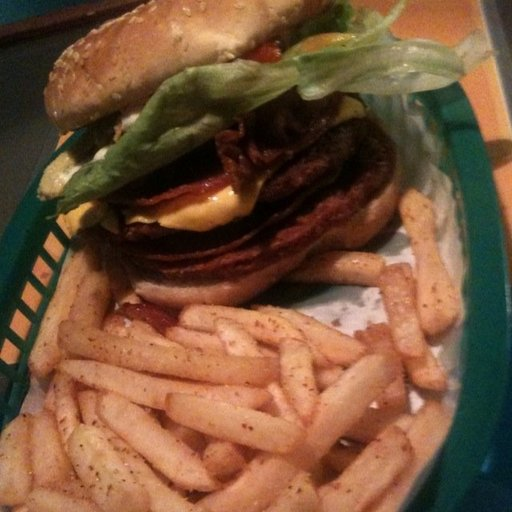

In [7]:
# Visualize an image
import random
from PIL import Image

# Set seed
# random.seed(42)

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))
print(image_path_list[:3])

# 2. Get random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Get image class from path name
image_class = random_image_path.parent.stem
print(image_class)

# 4. Open image
img = Image.open(random_image_path)

# Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img
# Image.open("/content/data/pizza_steak_sushi/test/pizza/194643.jpg")


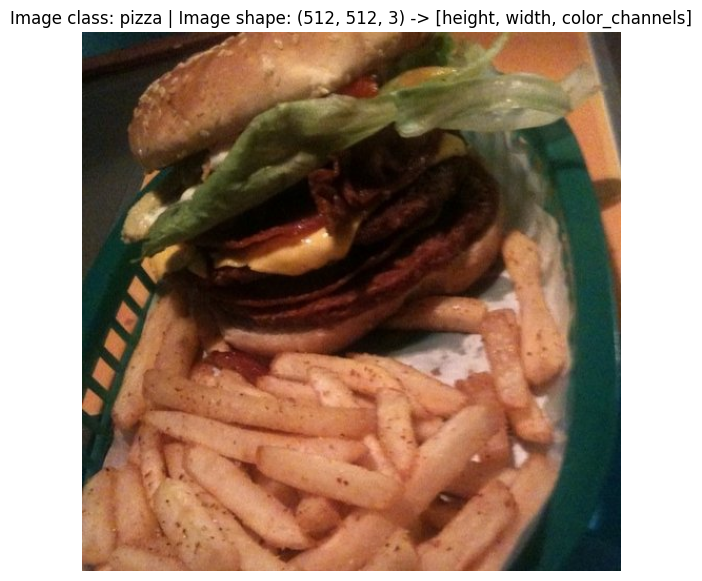

In [8]:
# Do the image visualization with matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

In [9]:
# 3.1 Transforming data with torchvision.transforms
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


In [10]:
# Write transform for turning images into tensors
data_transform = transforms.Compose([
  # Resize the images to 64x64x3 (64 height, 64 width, 3 color channels)
  transforms.Resize(size=(64, 64)),
  # Flip the images randomly on horizontal
  transforms.RandomHorizontalFlip(p=0.5),
  # Turn the image into a torch.Tensor
  transforms.ToTensor() # converts all pixel values from 0-255 to be between 0-1
])


In [11]:
random.sample(image_path_list, k=3)

[PosixPath('data/pizza_steak_sushi/train/sushi/17704.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/702165.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/1571146.jpg')]

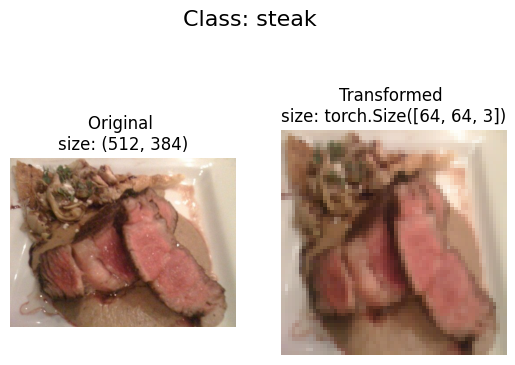

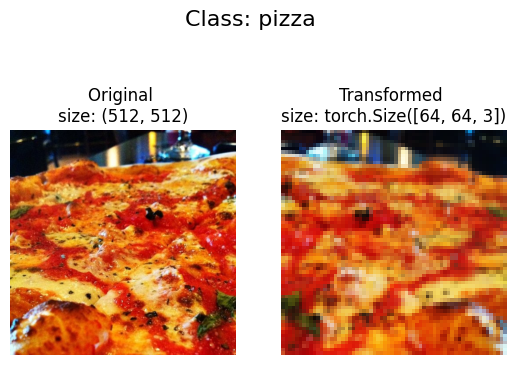

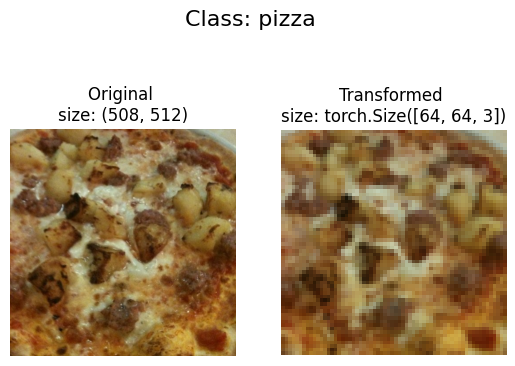

In [12]:
# Write a function to plot transformed images
def plot_transformed_images(image_paths, transform, n=3, seed=42):
  """Plots a series of random images from image_paths."""
  random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \nsize: {f.size}")
      ax[0].axis("off")

      # Transform and plot image
      # permute() the image to make sure it's compatible with matplotlib
      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \nsize: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3)

Load image data using ImageFolder

In [13]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform,
                                 target_transform=None)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [14]:
# Get class names as a list
class_names = train_data.classes
class_names


['pizza', 'steak', 'sushi']

In [15]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [16]:
# Check the lengths
len(train_data), len(test_data)


(225, 75)

In [17]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
BATCH_SIZE = 1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7c25a0c8f940>,
 <torch.utils.data.dataloader.DataLoader at 0x7c25a0c8f8e0>)

In [18]:
# How many batches of images are in our data loaders?
len(train_dataloader), len(test_dataloader)


(225, 75)

In [19]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


Q3. Recreate model_0 we built in section 7 of notebook 04.

In [20]:
import torch
from torch import nn

class TinyVGG(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*16*16,
                  out_features=output_shape))

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(f"Layer 1 shape: {x.shape}")
    x = self.conv_block_2(x)
    # print(f"Layer 2 shape: {x.shape}")
    x = self.classifier(x)
    # print(f"Layer 3 shape: {x.shape}")
    return x

In [21]:
model_0 = TinyVGG(input_shape = 3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [22]:
len(class_names)


3

In [23]:
16*16*10

2560

In [24]:
# Pass dummy data through model
dummy_x = torch.rand(size=[1, 3, 64, 64])
model_0(dummy_x.to(device))

tensor([[0.0031, 0.0040, 0.0085]], device='cuda:0', grad_fn=<AddmmBackward0>)

Q4. Create training and testing functions for model_0.

In [25]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):

  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader and data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X)
    # print(y_pred)

    # 2. Calculate and accumulate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate and accumualte accuracy metric across all batches
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and average accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc


In [26]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):

  # Put model in eval mode
  model.eval()

  # Setup the test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)
      # print(test_pred_logits)

      # 2. Calculuate and accumulate loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate and accumulate accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc



In [27]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)

    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results

Q5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?

- Use torch.optim.Adam() with a learning rate of 0.001 as the optimizer.


In [28]:
# Train for 5 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

loss_fn=nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        epochs=5)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1182 | train_acc: 0.2889 | test_loss: 1.0962 | test_acc: 0.3200
Epoch: 2 | train_loss: 1.1025 | train_acc: 0.3511 | test_loss: 1.1057 | test_acc: 0.2533
Epoch: 3 | train_loss: 1.1015 | train_acc: 0.3422 | test_loss: 1.0993 | test_acc: 0.3333
Epoch: 4 | train_loss: 1.0990 | train_acc: 0.3467 | test_loss: 1.0997 | test_acc: 0.3333
Epoch: 5 | train_loss: 1.0990 | train_acc: 0.3333 | test_loss: 1.1009 | test_acc: 0.3333


In [29]:
# Train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)

model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1182 | train_acc: 0.2889 | test_loss: 1.0962 | test_acc: 0.3200
Epoch: 2 | train_loss: 1.1025 | train_acc: 0.3467 | test_loss: 1.1054 | test_acc: 0.2533
Epoch: 3 | train_loss: 1.0999 | train_acc: 0.3244 | test_loss: 1.0998 | test_acc: 0.3333
Epoch: 4 | train_loss: 1.0990 | train_acc: 0.3200 | test_loss: 1.0999 | test_acc: 0.3333
Epoch: 5 | train_loss: 1.0990 | train_acc: 0.3378 | test_loss: 1.1004 | test_acc: 0.3333
Epoch: 6 | train_loss: 1.1001 | train_acc: 0.3600 | test_loss: 1.1003 | test_acc: 0.2933
Epoch: 7 | train_loss: 1.0966 | train_acc: 0.3422 | test_loss: 1.1319 | test_acc: 0.2533
Epoch: 8 | train_loss: 1.0894 | train_acc: 0.4311 | test_loss: 1.0302 | test_acc: 0.4533
Epoch: 9 | train_loss: 1.0134 | train_acc: 0.4622 | test_loss: 1.0159 | test_acc: 0.4133
Epoch: 10 | train_loss: 0.9816 | train_acc: 0.5244 | test_loss: 1.0558 | test_acc: 0.4267
Epoch: 11 | train_loss: 0.9507 | train_acc: 0.5689 | test_loss: 1.0316 | test_acc: 0.3867
Epoch: 12 | train_l

In [30]:
# Train for 50 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_2 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)

model_2_results = train(model=model_2,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        epochs=50)


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1179 | train_acc: 0.2800 | test_loss: 1.0960 | test_acc: 0.3733
Epoch: 2 | train_loss: 1.1010 | train_acc: 0.3244 | test_loss: 1.0996 | test_acc: 0.2533
Epoch: 3 | train_loss: 1.0993 | train_acc: 0.2978 | test_loss: 1.0998 | test_acc: 0.3333
Epoch: 4 | train_loss: 1.0983 | train_acc: 0.3422 | test_loss: 1.1804 | test_acc: 0.3333
Epoch: 5 | train_loss: 1.1047 | train_acc: 0.3511 | test_loss: 1.0998 | test_acc: 0.3333
Epoch: 6 | train_loss: 1.0989 | train_acc: 0.3467 | test_loss: 1.1003 | test_acc: 0.3333
Epoch: 7 | train_loss: 1.0985 | train_acc: 0.3467 | test_loss: 1.1010 | test_acc: 0.3333
Epoch: 8 | train_loss: 1.1002 | train_acc: 0.3333 | test_loss: 1.0923 | test_acc: 0.3467
Epoch: 9 | train_loss: 1.0752 | train_acc: 0.3911 | test_loss: 1.0814 | test_acc: 0.3200
Epoch: 10 | train_loss: 1.0189 | train_acc: 0.5422 | test_loss: 1.0526 | test_acc: 0.4000
Epoch: 11 | train_loss: 0.9508 | train_acc: 0.5600 | test_loss: 1.0210 | test_acc: 0.4400
Epoch: 12 | train_l

Q6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [31]:
# Double the number of hidden units and train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_3 = TinyVGG(input_shape=3,
                  hidden_units=20, # use 20 hidden units instead of 10
                  output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.001)

model_3_results = train(model=model_3,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        epochs=20) # train for 20 epochs

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0962 | train_acc: 0.3733 | test_loss: 1.0621 | test_acc: 0.3600
Epoch: 2 | train_loss: 0.9992 | train_acc: 0.5511 | test_loss: 1.0008 | test_acc: 0.4533
Epoch: 3 | train_loss: 0.9451 | train_acc: 0.5778 | test_loss: 1.0001 | test_acc: 0.4800
Epoch: 4 | train_loss: 0.8843 | train_acc: 0.6089 | test_loss: 0.9900 | test_acc: 0.5333
Epoch: 5 | train_loss: 0.8714 | train_acc: 0.6267 | test_loss: 1.0374 | test_acc: 0.4533
Epoch: 6 | train_loss: 0.8233 | train_acc: 0.6133 | test_loss: 0.9776 | test_acc: 0.4933
Epoch: 7 | train_loss: 0.8139 | train_acc: 0.6533 | test_loss: 1.0623 | test_acc: 0.4800
Epoch: 8 | train_loss: 0.7334 | train_acc: 0.6711 | test_loss: 1.0334 | test_acc: 0.4533
Epoch: 9 | train_loss: 0.6962 | train_acc: 0.6933 | test_loss: 1.1918 | test_acc: 0.4267
Epoch: 10 | train_loss: 0.6747 | train_acc: 0.7067 | test_loss: 1.0978 | test_acc: 0.4667
Epoch: 11 | train_loss: 0.6544 | train_acc: 0.7022 | test_loss: 1.0704 | test_acc: 0.4667
Epoch: 12 | train_l

Q7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?

In [32]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...")
    zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


In [33]:
# See how many images we have
walk_through_dir(image_path)


There are 2 directories and 0 images in 'data/pizza_steak_sushi_20_percent'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/test'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/pizza'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/sushi'.
There are 0 directories and 58 images in 'data/pizza_steak_sushi_20_percent/test/steak'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/train'.
There are 0 directories and 154 images in 'data/pizza_steak_sushi_20_percent/train/pizza'.
There are 0 directories and 150 images in 'data/pizza_steak_sushi_20_percent/train/sushi'.
There are 0 directories and 146 images in 'data/pizza_steak_sushi_20_percent/train/steak'.


In [34]:
# Turn the data into datasets and dataloaders
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [35]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

simple_transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.ToTensor()
])

train_data_20_percent = ImageFolder(train_data_20_percent_path,
                                    transform=simple_transform)

test_data_20_percent = ImageFolder(test_data_20_percent_path,
                                   transform=simple_transform)

# Create dataloaders
train_dataloader_20_percent = DataLoader(train_data_20_percent,
                                         batch_size=32,
                                         num_workers=os.cpu_count(),
                                         shuffle=True)

test_dataloader_20_percent = DataLoader(test_data_20_percent,
                                        batch_size=32,
                                        num_workers=os.cpu_count(),
                                        shuffle=False)

In [36]:
# Train a model with increased amount of data
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_4 = TinyVGG(input_shape=3,
                  hidden_units=20, # use 20 hidden units instead of 10
                  output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_4.parameters(), lr=0.001)

model_4_results = train(model=model_4,
                        train_dataloader=train_dataloader_20_percent, # use double the training data
                        test_dataloader=test_dataloader_20_percent, # use double the testing data
                        optimizer=optimizer,
                        epochs=20) # train for 20 epochs

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1041 | train_acc: 0.3312 | test_loss: 1.1005 | test_acc: 0.2875
Epoch: 2 | train_loss: 1.0837 | train_acc: 0.3563 | test_loss: 1.0690 | test_acc: 0.4676
Epoch: 3 | train_loss: 1.0308 | train_acc: 0.4375 | test_loss: 0.9597 | test_acc: 0.4955
Epoch: 4 | train_loss: 0.9115 | train_acc: 0.5521 | test_loss: 0.9143 | test_acc: 0.5687
Epoch: 5 | train_loss: 0.8633 | train_acc: 0.6375 | test_loss: 0.9285 | test_acc: 0.4898
Epoch: 6 | train_loss: 0.8188 | train_acc: 0.6562 | test_loss: 1.0457 | test_acc: 0.4528
Epoch: 7 | train_loss: 0.8832 | train_acc: 0.5833 | test_loss: 0.8766 | test_acc: 0.5943
Epoch: 8 | train_loss: 0.7730 | train_acc: 0.6667 | test_loss: 0.8832 | test_acc: 0.6074
Epoch: 9 | train_loss: 0.7982 | train_acc: 0.6375 | test_loss: 0.9303 | test_acc: 0.5023
Epoch: 10 | train_loss: 0.8048 | train_acc: 0.6396 | test_loss: 0.9157 | test_acc: 0.5727
Epoch: 11 | train_loss: 0.7859 | train_acc: 0.6500 | test_loss: 0.8592 | test_acc: 0.6318
Epoch: 12 | train_l

Q8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction.

In [37]:
# Get a custom image
custom_image = "pizza_dad.jpeg"
with open("pizza_dad.jpeg", "wb") as f:
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
  f.write(request.content)

In [38]:
# Load the image
import torchvision
img = torchvision.io.read_image(custom_image)
img

tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

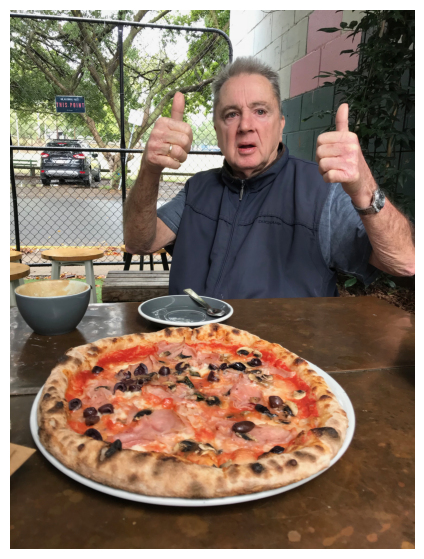

In [39]:
# View the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0)) # matplotlib likes images in HWC (height, width, color_channels) format not CHW (color_channels, height, width)
plt.axis(False);

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


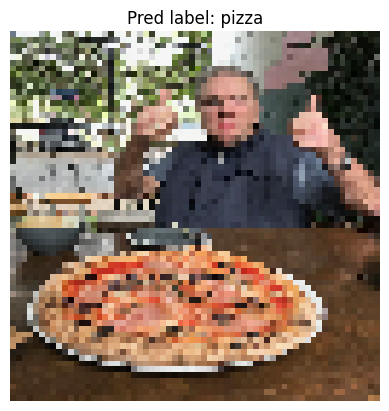

In [40]:
# Make a prediction on the image
model_4.eval()
with torch.inference_mode():
  # Get image pixels into float + between 0 and 1
  img = img / 255.

  # Resize image to 64x64
  resize = transforms.Resize((64, 64))
  img = resize(img)

  # Turn image in single batch and pass to target device
  batch = img.unsqueeze(0).to(device)

  # Predict on image
  y_pred_logit = model_4(batch)

  # Convert pred logit to pred label
  # pred_label = torch.argmax(torch.softmax(y_pred_logit, dim=1), dim=1)
  pred_label = torch.argmax(y_pred_logit, dim=1) # get same results as above without torch.softmax

# Plot the image and prediction
plt.imshow(img.permute(1, 2, 0))
plt.title(f"Pred label: {class_names[pred_label]}")
plt.axis(False);
